In [17]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='admin123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:\SKB\Courses\Data Analytics\Project 2\datasets'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='admin123',
    database='ecommerce'
)

cur = db.cursor()


# Basic Queries
## 1. List all unique cities where customers are located.

In [18]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

## 2. Count the number of orders placed in 2017.

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

# Extract the percentage value from the fetched data and convert it to a string
count = str(data[0][0])

# Format the output message with the percentage value
output_message = f"Number of orders placed in 2017 is {count}"

print(output_message)

Number of orders placed in 2017 is 270606


## 3. Find the total sales per category.

In [29]:
query = """ 
select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns=["Category","Sales"])

df

,Category,Sales
0,ART,774823.25
1,COOL STUFF,19492450.00
2,GAMES CONSOLES,4887009.48
3,TELEPHONY,12172051.27
4,SPORT LEISURE,34803188.98
...,...,...
69,CDS MUSIC DVDS,29985.75
70,LA CUISINE,72838.25
71,FASHION CHILDREN'S CLOTHING,19641.75
72,PC GAMER,54360.75


## 4. Calculate the percentage of orders that were paid in installments.

In [4]:
query = """ 
select sum(case when payment_installments >= 1 then 1 else 0 end) / count(*)*100 as percentage_of_orders
from payments;
"""

cur.execute(query)

data = cur.fetchall()

# Extract the percentage value from the fetched data and convert it to a string
percentage = str(data[0][0])

# Format the output message with the percentage value
output_message = f"The Percentage of orders that were paid in installments is {percentage}%"

print(output_message)

The Percentage of orders that were paid in installments is 99.9981%


## 5. Count the number of customers from each state. 

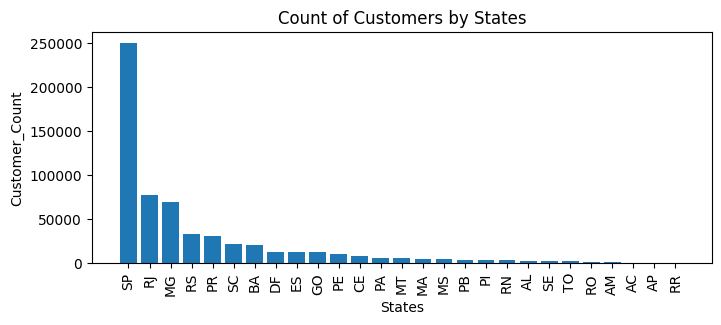

In [27]:
query = """ 
select customer_state, count(*) as customer_count
from customers
group by customer_state;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["State","Customer_Count"])

df = df.sort_values(by = "Customer_Count", ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df["State"], df["Customer_Count"])
plt.xticks( rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_Count")
plt.title("Count of Customers by States")
plt.show()